# Zillow4 - prices to rentals

This code explores prices to rentals.

In [13]:
import pandas as pd
import os
import plotly
import plotly.express as px
import numpy as np
import statsmodels.api as sm # regressions

In [14]:
# add save image function
%run ../../aid/save_image_plotly.ipynb

Function available: save_plotly(figure, filename)


In [15]:
# add time series clean function
%run functions/clean_TS.ipynb

Function clean_TS(dataframe, value_name)
Chose a value_name of your preference: 'index', 'price', 'Zri'...



In [16]:
# load data
%run Zillow1_loaddata.ipynb

Function load_zillow(geography ,tenure=all)
geography=('state'/'county'), tenure=('rentals'/'prices'/'all')



In [17]:
load_zillow('state', 'all') # load rental and prices datasets

S_Zri_All ../input/zri/State_Zri_AllHomesPlusMultifamily.csv
S_Zri_MFR ../input/zri/State_Zri_MultiFamilyResidenceRental.csv
S_Zri_Als ../input/zri/State_Zri_AllHomesPlusMultifamily_Summary.csv
S_Zhvi_All ../input/zhvi/State_Zhvi_AllHomes.csv
S_Zhvi_SFR ../input/zhvi/State_Zhvi_SingleFamilyResidence.csv
S_Zhvi_Bot ../input/zhvi/State_Zhvi_BottomTier.csv
S_Zhvi_Top ../input/zhvi/State_Zhvi_TopTier.csv


In [18]:
# raw data is in this folder on subdirectories
input_folder = '../input'

In [19]:
# set to new tables, so wont change original
price_tbl = clean_TS(S_Zhvi_All,'price')
rental_tbl = clean_TS(S_Zri_All,'rental')

In [20]:
# convert dates on price table to same pattern in rental table, so we can merge
price_tbl['Date'] = price_tbl['Date'].str.extract('(\d+-\d+)')

#### Clean and merge rental and prices datasets

In [21]:
def df_cat(dfx, category):
    '''cleans TS (long format) and add categorical column'''
    
    df  = clean_TS(dfx, 'price')
    df['category'] = category
    return df

In [22]:
# concatenate long form of all tables, with categories
price_all_tiers = pd.concat([df_cat(S_Zhvi_Top, 'top'),
                             df_cat(S_Zhvi_All, 'mid'),
                             df_cat(S_Zhvi_Bot, 'bottom'),
                             df_cat(S_Zhvi_SFR, 'SFR')]).reset_index(drop=True)

In [23]:
# merge tables, keeping only common dates (series for rentals is shorter)
pricerent =  (rental_tbl[['RegionName', 'Date', 'rental']].
             merge(price_tbl[['RegionName', 'Date', 'price', 'StateName']], how='left', on=['RegionName', 'Date']))

In [24]:
# new column with price-to-rentals
pricerent['pricerent']=pricerent.price/(pricerent.rental*12)

### Price to rent time series - all homes

In [26]:
fig = px.line(pricerent.sort_values(by=['RegionName', 'Date']),
              x="Date", 
              y="pricerent",
              facet_col='RegionName', 
              facet_col_wrap=8,
              title='Price to rent (All Homes)',
              template="plotly_white",
              labels= {'RegionName':'',
                       'Date':'',
                      'pricerent':''},
              height=1000)

# Show only values on facet labels
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("=", "")))
fig.show()


Reminder:
Price to rent 10, 15, 20 = 10%, 6.6% and 5% rental yield

### Annual percentual changes - price-to-rent - all homes

In [31]:
df_y = pricerent.copy()

In [32]:
df_y.head(3)

,RegionName,Date,rental,price,StateName,pricerent
0,California,2010-09,2015.0,332750.0,CA,13.761373
1,District of Columbia,2010-09,1943.0,425233.0,DC,18.237820
2,Hawaii,2010-09,2131.0,473684.0,HI,18.523541


In [33]:
# only December dates
df_y = df_y[df_y.Date.str.contains('-12')] # YYYY-12

In [34]:
# add column
df_y['pct_change'] = df_y.groupby('RegionName')['pricerent'].apply(lambda x: x.pct_change())

In [35]:
df_y 

,RegionName,Date,rental,price,StateName,pricerent,pct_change
153,California,2010-12,2011.0,326613.0,CA,13.534436,NaN
154,District of Columbia,2010-12,1974.0,421496.0,DC,17.793651,NaN
155,Hawaii,2010-12,2157.0,476291.0,HI,18.400981,NaN
156,New York,2010-12,1598.0,262806.0,NY,13.704944,NaN
157,Massachusetts,2010-12,1610.0,317476.0,MA,16.432505,NaN
...,...,...,...,...,...,...,...
5707,Kansas,2019-12,956.0,152336.0,KS,13.278940,0.023709
5708,Iowa,2019-12,950.0,154005.0,IA,13.509211,0.038758
5709,Oklahoma,2019-12,904.0,130401.0,OK,12.020741,0.038561
5710,West Virginia,2019-12,896.0,106967.0,WV,9.948568,0.026726


In [36]:
fig = px.bar(df_y.sort_values(by=['RegionName', 'Date']),
              x="Date", 
              y="pct_change",
              facet_col='RegionName', 
              facet_col_wrap=8,
              title='Price to rent - % change(All Homes)',
              template="plotly_white",
              labels= {'RegionName':'',
                       'Date':'',
                      'pct_change':''},
              height=1200)
fig.update_layout(uniformtext_minsize=3, uniformtext_mode='hide')

# Show only values on facet labels
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("=", "")))
fig.show()


### Price x price-to-rent

In [37]:
df = (pricerent[pricerent.Date==pricerent.Date.max()].sort_values(by=['RegionName', 'Date']))

In [38]:
price_tbl.head(3)

,RegionID,SizeRank,RegionName,RegionType,StateName,Date,price
0,18,39,Hawaii,State,HI,1996-01,246670.0
1,12,49,District of Columbia,State,DC,1996-01,166900.0
2,9,0,California,State,CA,1996-01,162238.0


In [39]:
## add census to divisions to new colum

# load file w/ census divisions and make dictionary 
census = pd.read_csv('../../CENSUS/output/state_reg_div.csv', index_col='state').iloc[:,:2].to_dict()

# add new column to dataframe with divisions
df['division'] = df['RegionName'].map(census['division'])

In [40]:
# regression
#df['bestfit'] = sm.OLS(df['pricerent'],sm.add_constant(df['price'])).fit().fittedvalues

In [41]:
fig = px.scatter(df.sort_values(by=['price']), 
                 x ="price", 
                 y="pricerent", 
                 #color="division",  
                 color_discrete_sequence=px.colors.qualitative.Set2,
                 text="StateName", 
                 log_x=True,log_y=True,
                 trendline="ols"
                )
# colored dots
for i in range(len(set(df.division))):
    fig.add_trace(px.scatter(df, x='price', y='pricerent',color="division", ).data[i])

fig.update_traces(textposition='top center', textfont_size=10)
fig.update_layout(xaxis_title = 'price', yaxis_title = 'price-to-rent', template="plotly_white",)
fig.show()

### Price-to-rent geographical distribution

In [42]:
df.head()

,RegionName,Date,rental,price,StateName,pricerent,division
5753,Alabama,2020-01,1017.0,141474.0,AL,11.592429,East South Central
5727,Alaska,2020-01,1531.0,305820.0,AK,16.645983,Pacific
5733,Arizona,2020-01,1414.0,273147.0,AZ,16.097772,Mountain
5762,Arkansas,2020-01,899.0,130053.0,AR,12.055339,West South Central
5712,California,2020-01,2560.0,569813.0,CA,18.548600,Pacific


In [43]:
fig_map_prices = px.choropleth(df, locationmode="USA-states", 
                    scope="usa",
                    color="pricerent",
                    locations="StateName", 
                    featureidkey="properties.district",
                    title='Price to rent' ,
                    hover_name = 'RegionName',
                    width=800, height=500,
                    color_continuous_scale='ylgnbu',
                    range_color=[df['pricerent'].min(), df['pricerent'].max()] # set the range color to mach min and maximum prices
                   )
#save_plotly(fig_map_prices, 'map_prices_S.png')
fig_map_prices.show()

A new pattern emerges: states on the West Region (Divisions 'Pacific' and 'Mountain') have much higher price to rentals. Price to rentals in CA are similar then the other states on this Region. For reference, I present maps saved when running 2 other codes (`Zillow1_rentals.ipynb` and `Zillow2_prices.ipynb`). I set the maps so that their color scale matches the minimum and maximum for prices and rents, for reference, before we look at the map of price-to-rent.

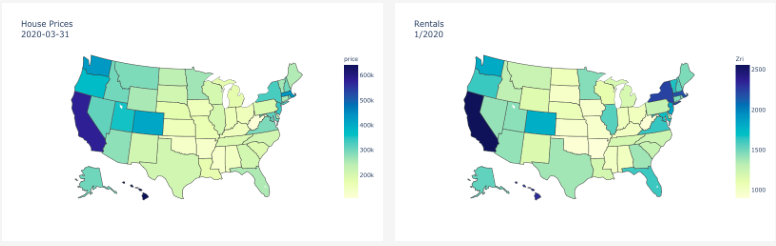